In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import zipfile
zip_path = "/content/drive/MyDrive/ML/data.zip"
unzip_path = "/content/data"
if not os.path.exists(unzip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_path)

In [3]:
import warnings

import numpy as np
import pandas as pd

import cv2
from PIL import Image
from matplotlib import pyplot as plt
import os
import sys
import warnings
import timm

import torch
import torch.nn as nn
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")

models: VGG

In [4]:
class VggFeatures(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        # print(x.shape)

        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))

        return x


class Vgg(VggFeatures):
    def __init__(self, drop=0.2):
        super().__init__(drop)
        self.lin3 = nn.Linear(4096, 7)

    def forward(self, x):
        x = super().forward(x)
        x = self.lin3(x)
        return x

models: EFN

In [5]:
class EfficientNet(nn.Module):
    def __init__(self, pretrained=True, drop=0.1):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b3_ns', pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 7)

    def forward(self, x):
        # print(x.shape)
        x = x.repeat(1, 3, 1, 1)
        # print(x.shape)

        x = self.model(x)
        return x

hparams

In [52]:
hps = {
    'network': 'vgg',  # which network do you want to train
    'name': 'my_vgg100',  # whatever you want to name your run
    'n_epochs': 100,
    'model_save_dir': "/content/drive/MyDrive/ML/",  # where will checkpoints be stored (path created automatically using hps[name])
    'restore_epoch': None,  # continue training from a specific saved point
    'start_epoch': 0,
    'lr': 0.01,  # starting learning rate
    'save_freq': 20,  # how often to create checkpoints
    'drop': 0.1,
    'bs': 64,
}

possible_nets = {'vgg'}

def setup_hparams():
    # invalid parameter check
    try:
        hps['n_epochs'] = int(hps['n_epochs'])
        hps['start_epoch'] = int(hps['start_epoch'])
        hps['save_freq'] = int(hps['save_freq'])
        hps['lr'] = float(hps['lr'])
        hps['drop'] = float(hps['drop'])
        hps['bs'] = int(hps['bs'])

        if hps['restore_epoch']:
            hps['restore_epoch'] = int(hps['restore_epoch'])
            hps['start_epoch'] = int(hps['restore_epoch'])

        # make sure we can checkpoint regularly or at least once (at the end)
        if hps['n_epochs'] < 20:
            hps['save_freq'] = min(5, hps['n_epochs'])

    except Exception as e:
        raise ValueError("Invalid input parameters")

    # create checkpoint directory
    hps['model_save_dir'] = os.path.join(os.getcwd(), 'checkpoints', hps['name'])

    if not os.path.exists(hps['model_save_dir']):
        os.makedirs(hps['model_save_dir'])

    return hps

logger

In [53]:
class Logger:
    def __init__(self):
        self.loss_train = []
        self.loss_val = []

        self.acc_train = []
        self.acc_val = []

    def get_logs(self):
        return self.loss_train, self.loss_val, self.acc_train, self.acc_val

    def restore_logs(self, logs):
        self.loss_train, self.loss_val, self.acc_train, self.acc_val = logs

    def save_plt(self, hps):
        loss_path = os.path.join(hps['model_save_dir'], 'loss.jpg')
        acc_path = os.path.join(hps['model_save_dir'], 'acc.jpg')

        plt.figure()
        plt.plot(self.acc_train, 'g', label='Training Acc')
        plt.plot(self.acc_val, 'b', label='Validation Acc')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Acc')
        plt.legend()
        plt.grid()
        plt.savefig(acc_path)

        plt.figure()
        plt.plot(self.loss_train, 'g', label='Training Loss')
        plt.plot(self.loss_val, 'b', label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.savefig(loss_path)

checkpoints

In [54]:
def save(net, logger, hps, epoch):
    # Create the path the checkpint will be saved at using the epoch number
    path = os.path.join(hps['model_save_dir'], 'epoch_' + str(epoch))

    # create a dictionary containing the logger info and model info that will be saved
    checkpoint = {
        'logs': logger.get_logs(),
        'params': net.state_dict()
    }

    # save checkpoint
    torch.save(checkpoint, path)


def restore(net, logger, hps):
    """ Load back the model and logger from a given checkpoint
        epoch detailed in hps['restore_epoch'], if available"""
    path = os.path.join(hps['model_save_dir'], 'epoch_' + str(hps['restore_epoch']))

    if os.path.exists(path):
        try:
            checkpoint = torch.load(path)

            logger.restore_logs(checkpoint['logs'])
            net.load_state_dict(checkpoint['params'])
            print("Network Restored!")

        except Exception as e:
            print("Restore Failed! Training from scratch.")
            print(e)
            hps['start_epoch'] = 0

    else:
        print("Restore point unavailable. Training from scratch.")
        hps['start_epoch'] = 0


def load_features(model, params):
    """ Load params into all layers of 'model'
        that are compatible, then freeze them"""
    model_dict = model.state_dict()

    imp_params = {k: v for k, v in params.items() if k in model_dict}

    # Load layers
    model_dict.update(imp_params)
    model.load_state_dict(imp_params)

    # Freeze layers
    for name, param in model.named_parameters():
        param.requires_grad = False

loops

In [23]:
from torch.cuda.amp import autocast

In [55]:
def train(net, dataloader, criterion, optimizer, scaler, Ncrop=True):
    net = net.train()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    iters = len(dataloader)  # number of batches, not images

    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with autocast():
            if Ncrop:
                # fuse crops and batchsize
                bs, ncrops, c, h, w = inputs.shape
                inputs = inputs.view(-1, c, h, w)

            # repeat labels ncrops times
            labels = torch.repeat_interleave(labels, repeats=ncrops, dim=0)

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            # scheduler.step(epoch + i / iters)

            # calculate performance metrics
            loss_tr += loss.item()

            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss


def evaluate(net, dataloader, criterion, Ncrop=True):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        if Ncrop:
            # fuse crops and batchsize
            bs, ncrops, c, h, w = inputs.shape
            inputs = inputs.view(-1, c, h, w)
            # forward
            outputs = net(inputs)
            # combine results across the crops
            outputs = outputs.view(bs, ncrops, -1)
            outputs = torch.sum(outputs, dim=1) / ncrops
        else:
            outputs = net(inputs)

        loss = criterion(outputs, labels)

        # calculate performance metrics
        loss_tr += loss.item()

        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss

setup_network

In [56]:
nets = {
    'vgg': Vgg,
    # 'efn': EfficientNet
}

def setup_network(hps):
    net = nets[hps['network']]()

    # Prepare logger
    logger = Logger()
    if hps['restore_epoch']:
        restore(net, logger, hps)

    return logger, net

dataset

In [57]:
batch_size = 64
mu, st = 0, 255
# Train and validation transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
    transforms.Grayscale(num_output_channels=1),
    transforms.TenCrop(40),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
    transforms.Lambda(lambda tensors: torch.stack([transforms.RandomErasing(p=0.5)(t) for t in tensors])),
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.TenCrop(40),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
])

# Train dataset
train_dataset = datasets.ImageFolder(root=f"{unzip_path}/data/Images/train", transform=train_transform)

# Validation dataset with test_transform
val_dataset = datasets.ImageFolder(root=f"{unzip_path}/data/Images/train", transform=test_transform)

# Split indices for train and validation datasets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_indices, val_indices = torch.utils.data.random_split(range(len(train_dataset)), [train_size, val_size])

# Apply indices to separate datasets
train_data = torch.utils.data.Subset(train_dataset, train_indices)
val_data = torch.utils.data.Subset(val_dataset, val_indices)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [58]:
for images, labels in train_loader:
    print(images.shape)  # 應輸出 [batch_size, 1, 48, 48]
    break
for images, labels in val_loader:
    print(images.shape)  # 應輸出 [batch_size, 1, 48, 48]
    break

torch.Size([64, 10, 1, 40, 40])
torch.Size([64, 10, 1, 40, 40])


train.py

In [59]:
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

def run(net, logger, hps):
    # Create dataloaders
    # trainloader, valloader, testloader = get_dataloaders(bs=hps['bs'])

    net = net.to(device)

    learning_rate = float(hps['lr'])
    scaler = GradScaler()

    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=0.0001)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0

    print("Training", hps['name'], "on", device)
    for epoch in range(hps['start_epoch'], hps['n_epochs']):

        acc_tr, loss_tr = train(net, train_loader, criterion, optimizer, scaler)
        logger.loss_train.append(loss_tr)
        logger.acc_train.append(acc_tr)

        acc_v, loss_v = evaluate(net, val_loader, criterion)
        logger.loss_val.append(loss_v)
        logger.acc_val.append(acc_v)

        # Update learning rate
        scheduler.step(acc_v)

        if acc_v > best_acc:
            best_acc = acc_v

            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        if (epoch + 1) % hps['save_freq'] == 0:
            save(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        print('Epoch %2d' % (epoch + 1),
              'Train Accuracy: %2.4f %%' % acc_tr,
              'Val Accuracy: %2.4f %%' % acc_v,
              sep='\t\t')

In [60]:
hyperparameters = setup_hparams()
print(hyperparameters)

{'network': 'vgg', 'name': 'my_vgg100', 'n_epochs': 100, 'model_save_dir': '/content/checkpoints/my_vgg100', 'restore_epoch': None, 'start_epoch': 0, 'lr': 0.01, 'save_freq': 20, 'drop': 0.1, 'bs': 64}


In [ ]:
# if __name__ == "__main__":
#     train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
#     val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
#     hps = setup_hparams()
#     logger, net = setup_network(hps)
#     run(net, logger, hps)

Training my_vgg100 on cuda:0
Epoch  1		Train Accuracy: 31.4935 %		Val Accuracy: 48.9028 %
Epoch  2		Train Accuracy: 45.3421 %		Val Accuracy: 48.2062 %
Epoch  3		Train Accuracy: 51.2276 %		Val Accuracy: 54.5106 %
Epoch  4		Train Accuracy: 54.2554 %		Val Accuracy: 59.0038 %
Epoch  5		Train Accuracy: 56.0190 %		Val Accuracy: 52.8039 %
Epoch  6		Train Accuracy: 57.4042 %		Val Accuracy: 55.6252 %
Epoch  7		Train Accuracy: 58.6036 %		Val Accuracy: 63.1487 %
Epoch  8		Train Accuracy: 59.6540 %		Val Accuracy: 57.0881 %
Epoch  9		Train Accuracy: 60.7849 %		Val Accuracy: 55.4859 %
Epoch 10		Train Accuracy: 61.7749 %		Val Accuracy: 63.7757 %
Epoch 11		Train Accuracy: 62.2335 %		Val Accuracy: 58.5510 %
Epoch 12		Train Accuracy: 62.8013 %		Val Accuracy: 63.7409 %
Epoch 13		Train Accuracy: 63.5494 %		Val Accuracy: 64.3678 %
Epoch 14		Train Accuracy: 64.2225 %		Val Accuracy: 62.2083 %
Epoch 15		Train Accuracy: 64.8305 %		Val Accuracy: 51.1668 %
Epoch 16		Train Accuracy: 65.5902 %		Val Accuracy: 56.53

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e606b75f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e606b75f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 41		Train Accuracy: 80.5720 %		Val Accuracy: 66.0745 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e606b75f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e606b75f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 42		Train Accuracy: 80.9045 %		Val Accuracy: 65.8307 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e606b75f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e606b75f9a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 43		Train Accuracy: 81.2358 %		Val Accuracy: 70.7419 %
Epoch 44		Train Accuracy: 81.5497 %		Val Accuracy: 68.2341 %
Epoch 45		Train Accuracy: 82.0532 %		Val Accuracy: 28.9794 %
Epoch 46		Train Accuracy: 82.3632 %		Val Accuracy: 18.3560 %
Epoch 47		Train Accuracy: 82.5261 %		Val Accuracy: 63.7060 %
Epoch 48		Train Accuracy: 82.8207 %		Val Accuracy: 53.3612 %
Epoch 49		Train Accuracy: 83.0827 %		Val Accuracy: 68.2341 %
Epoch 50		Train Accuracy: 84.3633 %		Val Accuracy: 67.2936 %
Epoch 51		Train Accuracy: 84.7465 %		Val Accuracy: 69.2093 %
Epoch 52		Train Accuracy: 84.9865 %		Val Accuracy: 65.0644 %
Epoch 53		Train Accuracy: 85.1335 %		Val Accuracy: 37.5827 %
Epoch 54		Train Accuracy: 85.3565 %		Val Accuracy: 64.5071 %
Epoch 55		Train Accuracy: 85.8178 %		Val Accuracy: 68.6520 %
Epoch 56		Train Accuracy: 86.3712 %		Val Accuracy: 69.5576 %
Epoch 57		Train Accuracy: 86.9700 %		Val Accuracy: 46.0118 %
Epoch 58		Train Accuracy: 87.1910 %		Val Accuracy: 70.2891 %
Epoch 59		Train Accuracy

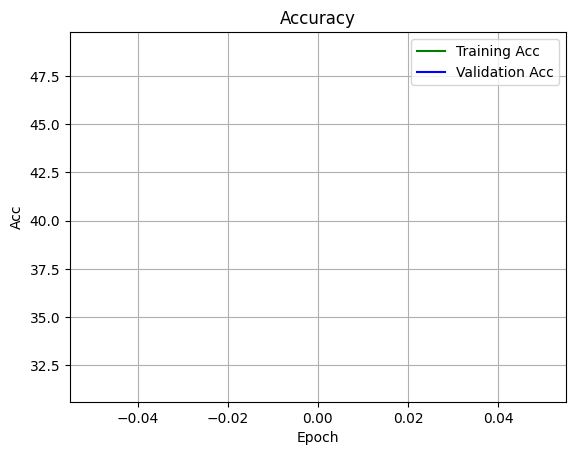

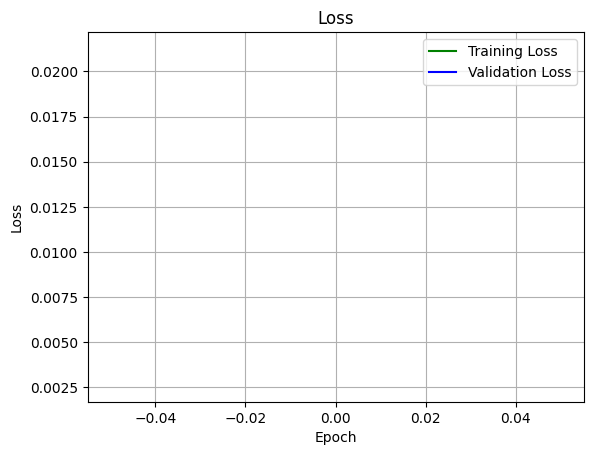

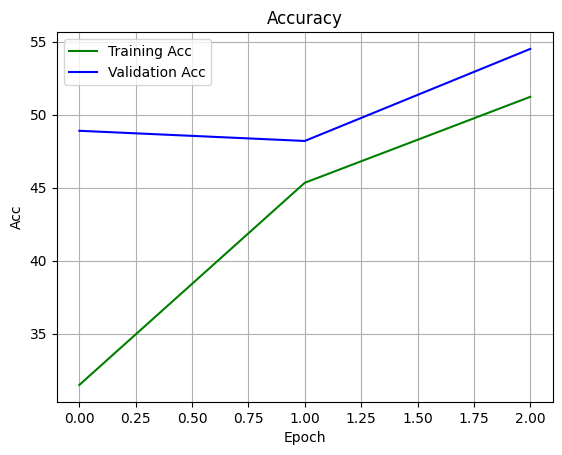

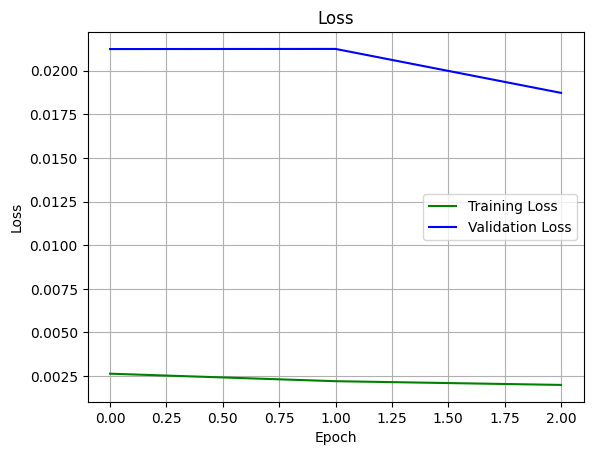

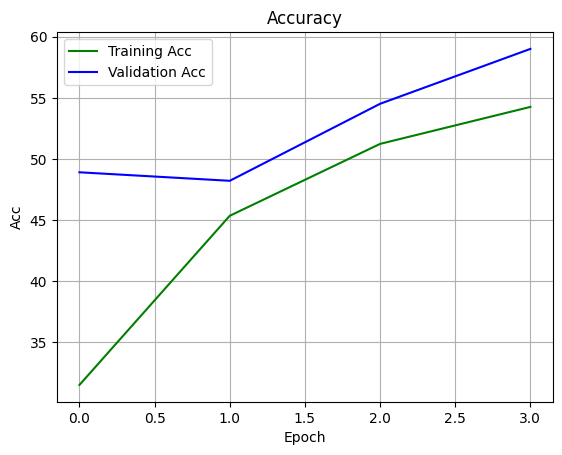

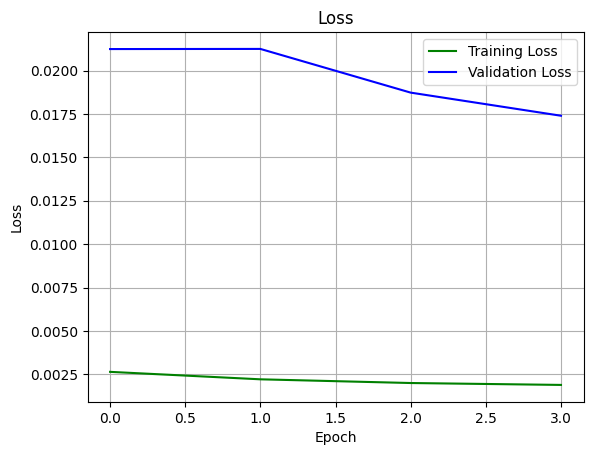

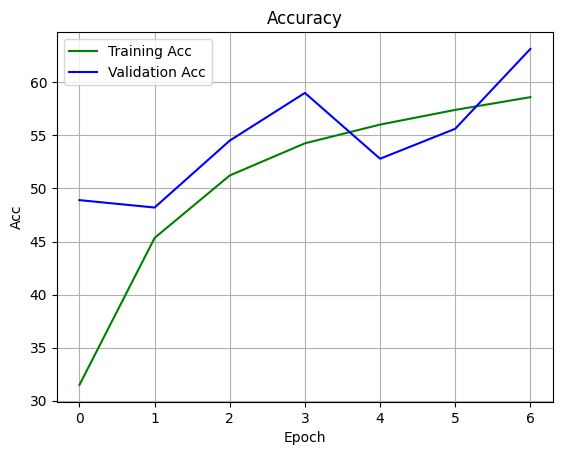

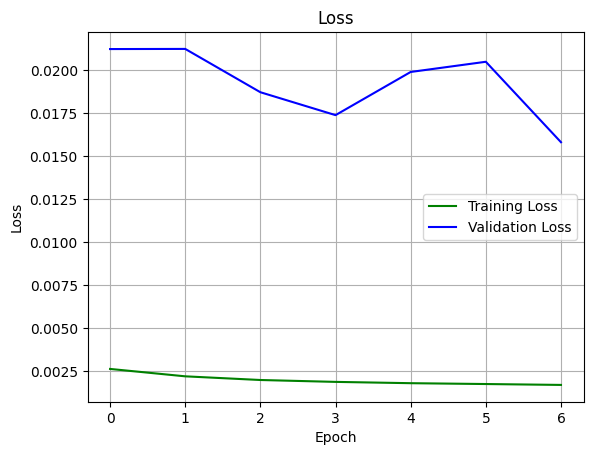

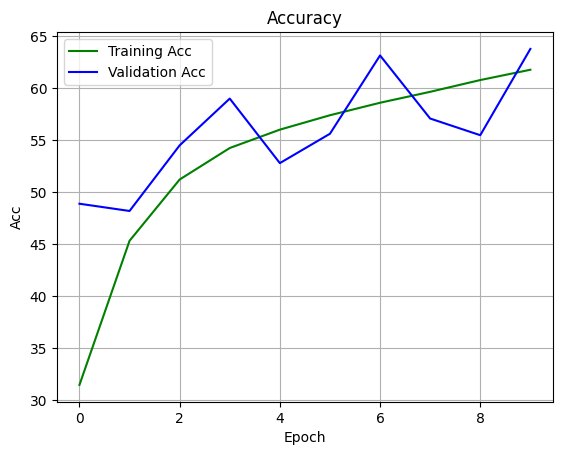

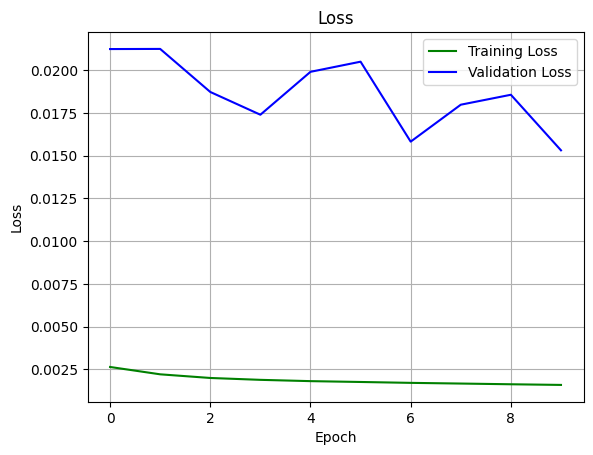

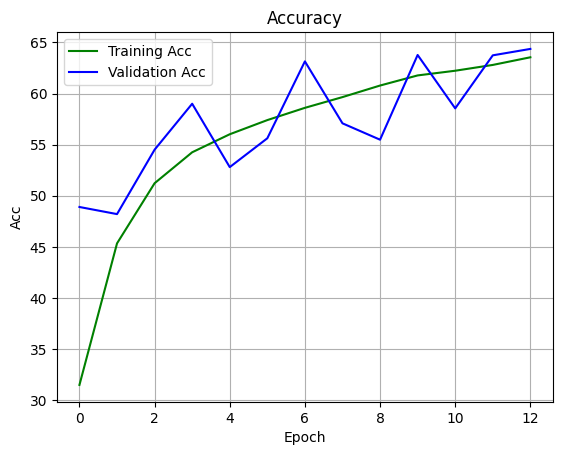

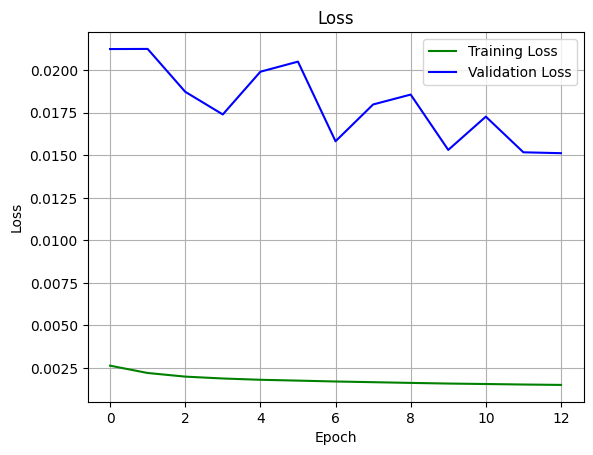

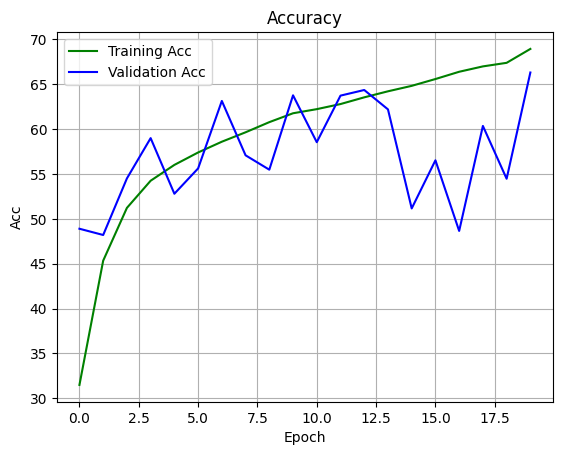

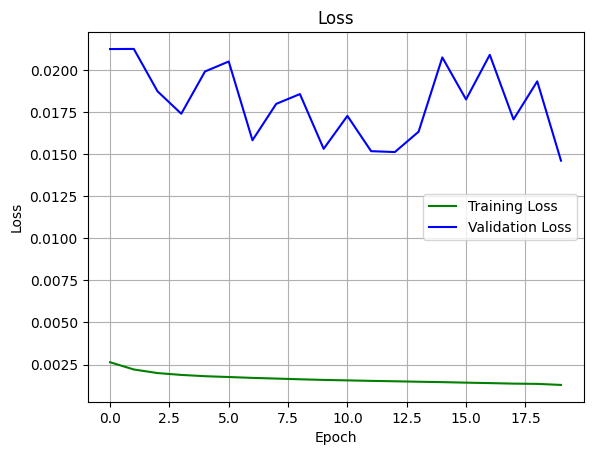

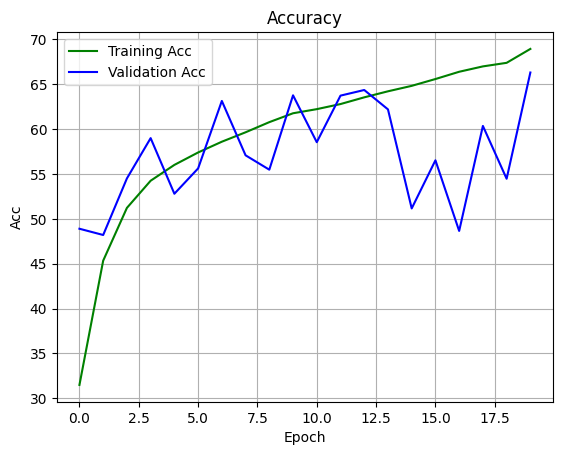

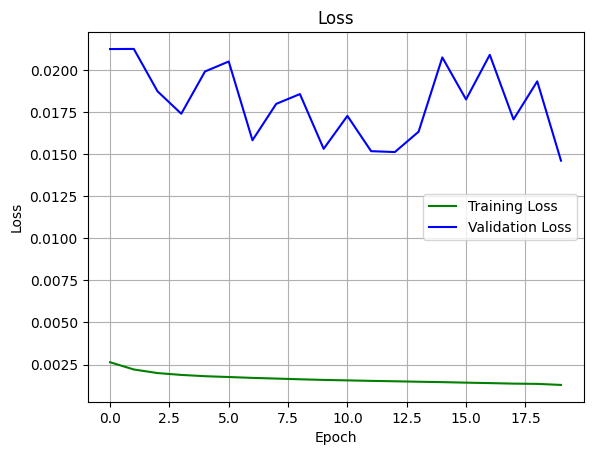

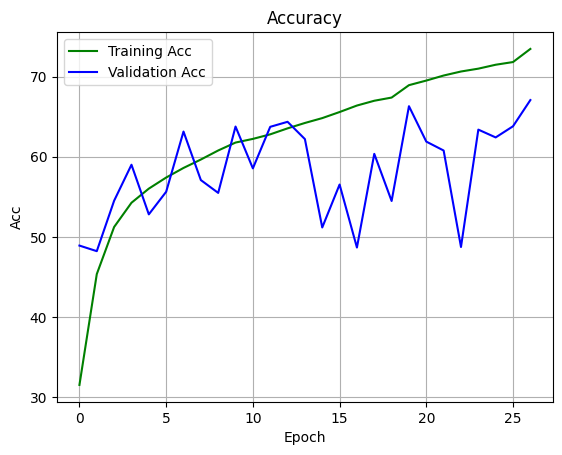

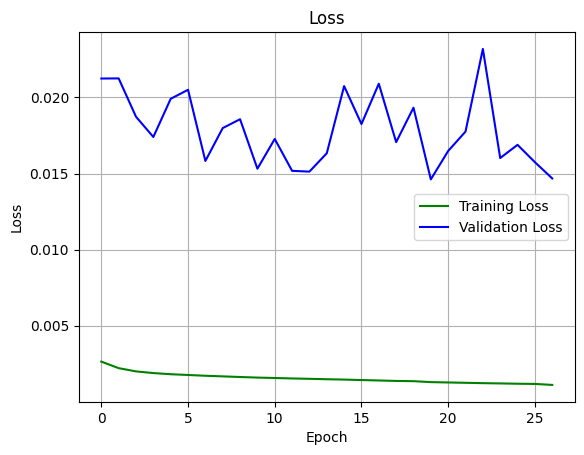

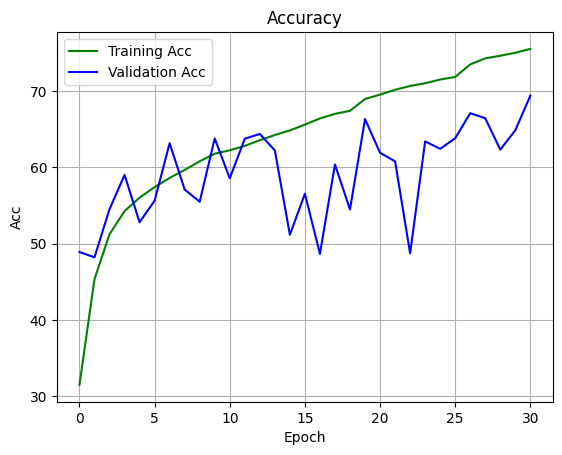

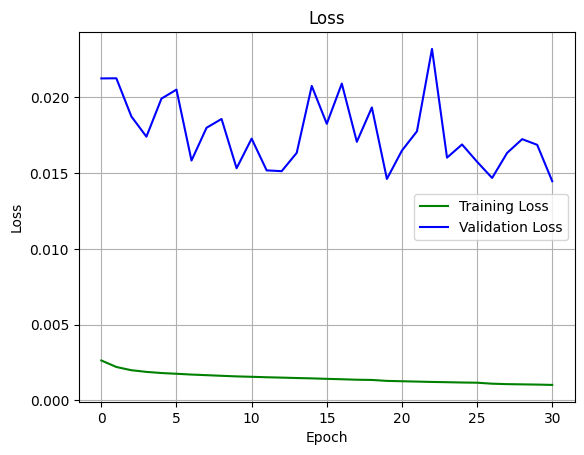

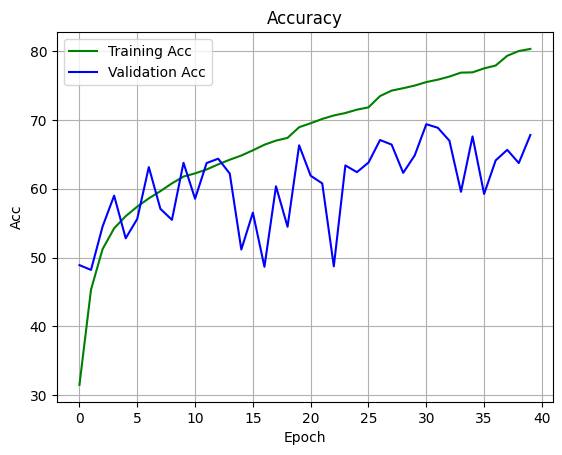

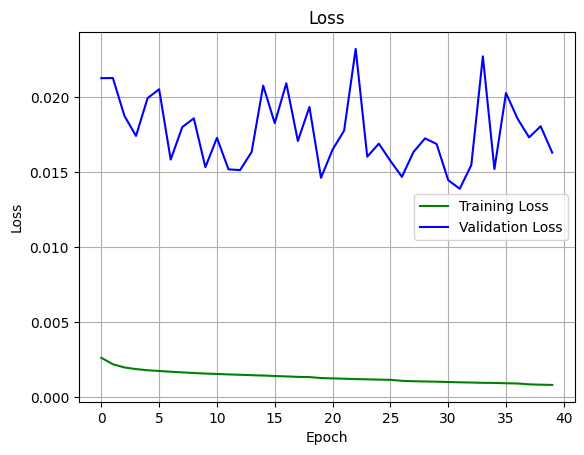

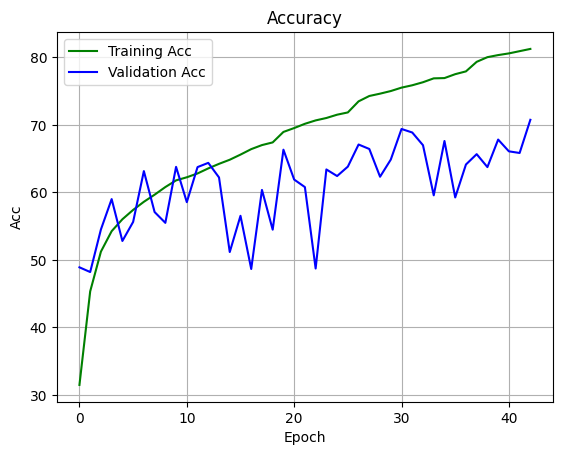

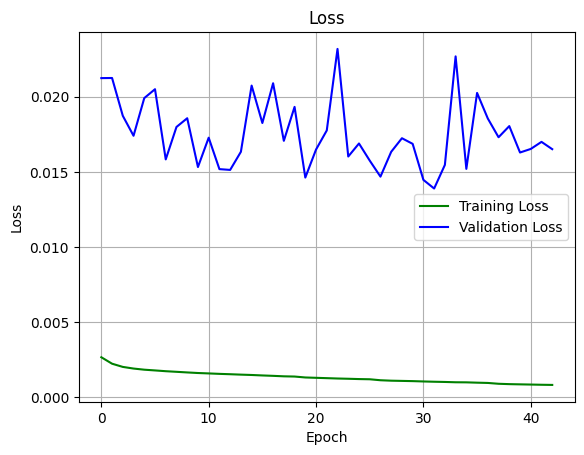

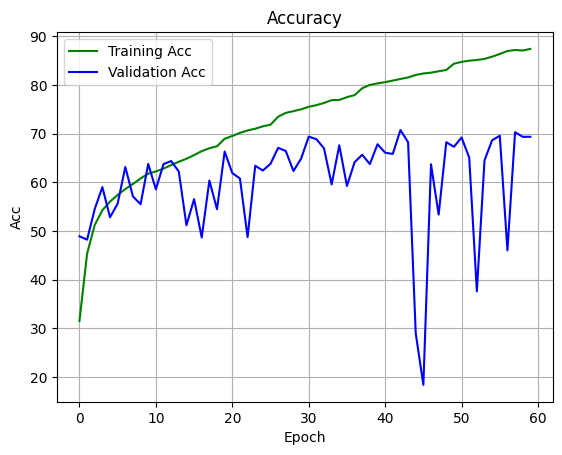

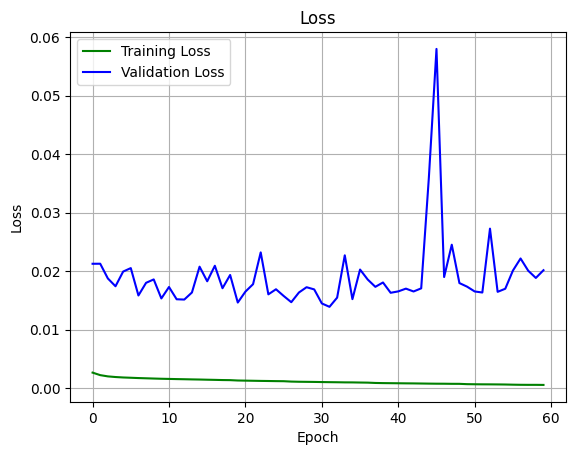

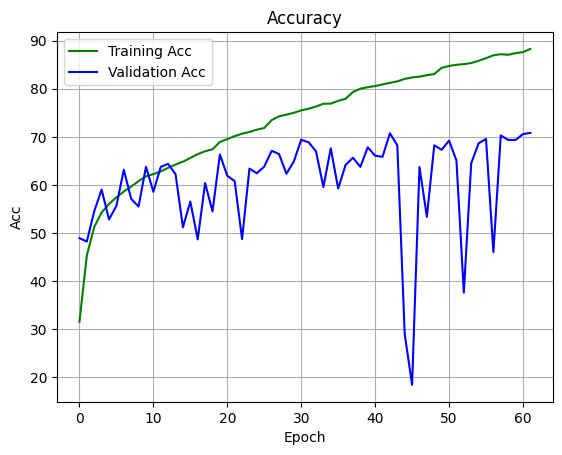

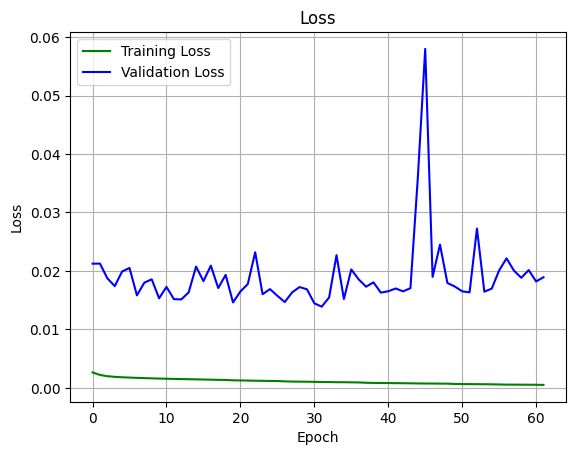

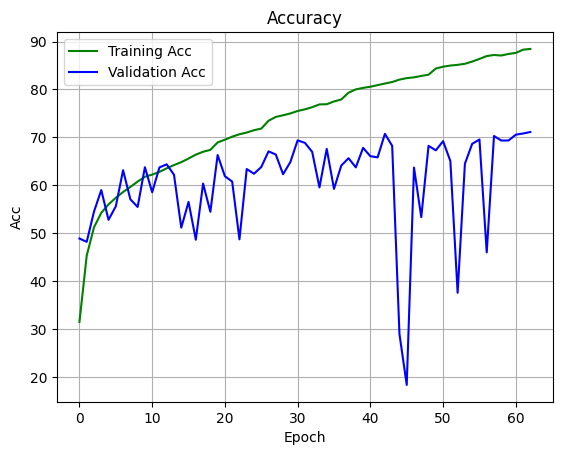

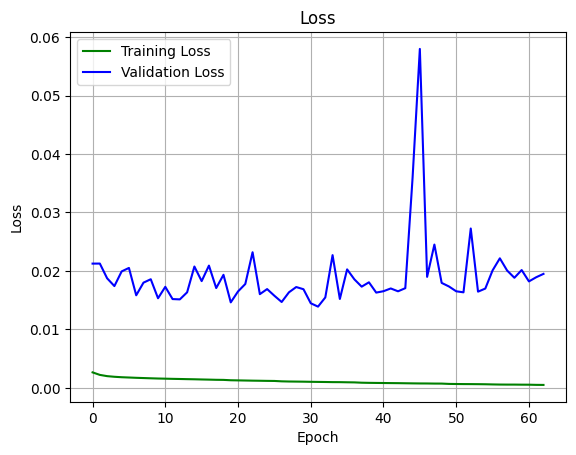

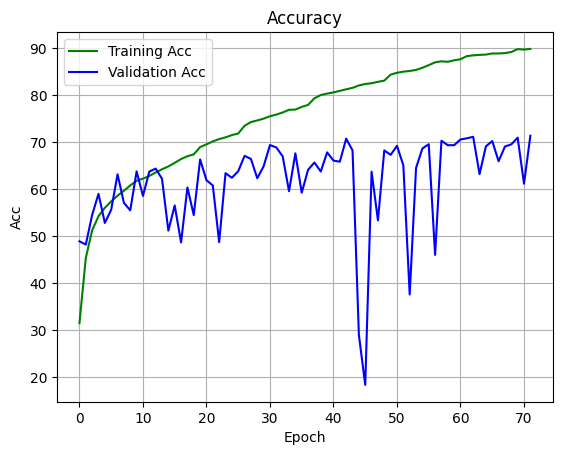

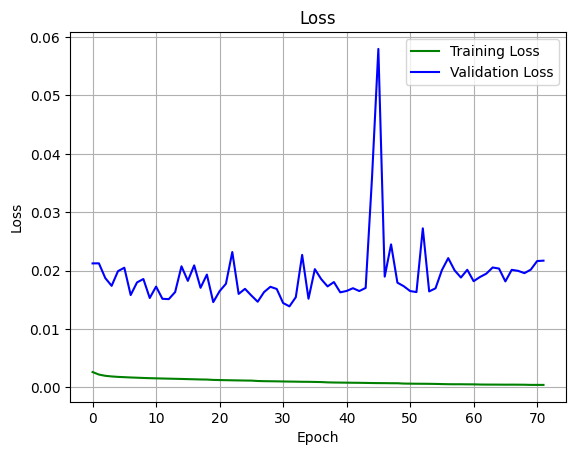

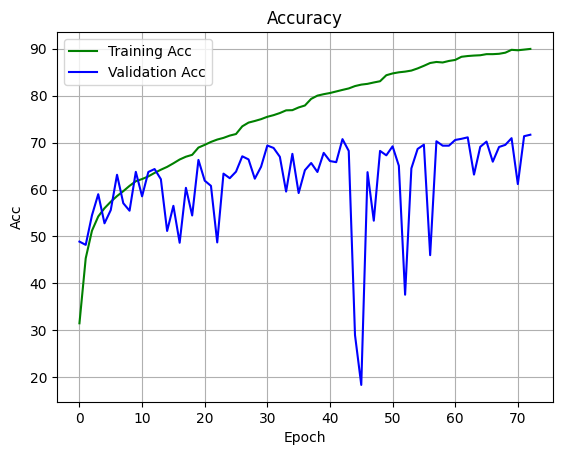

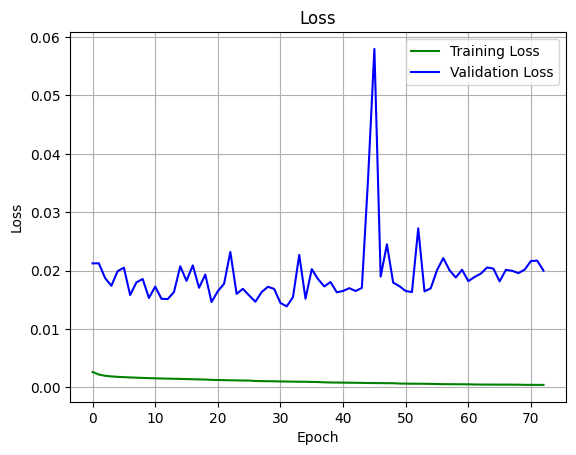

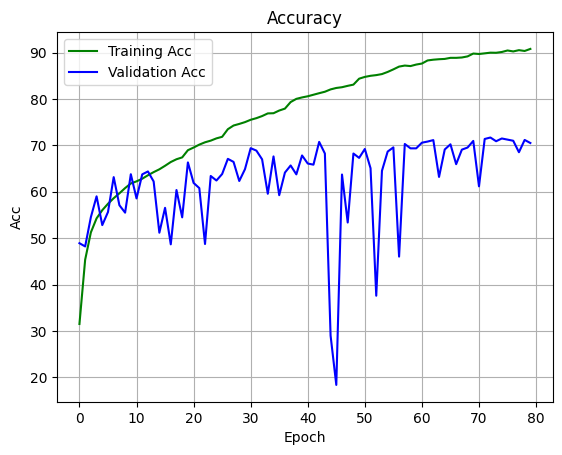

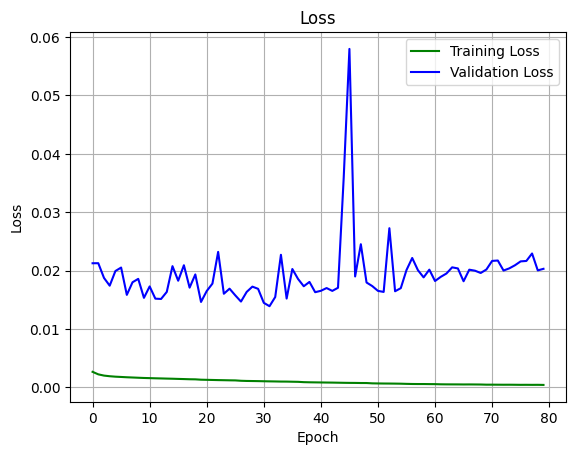

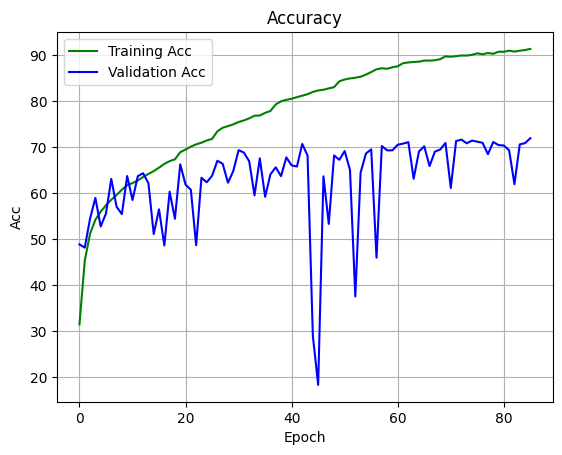

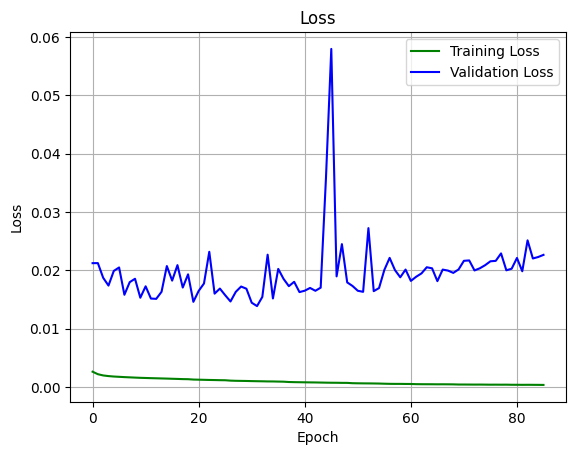

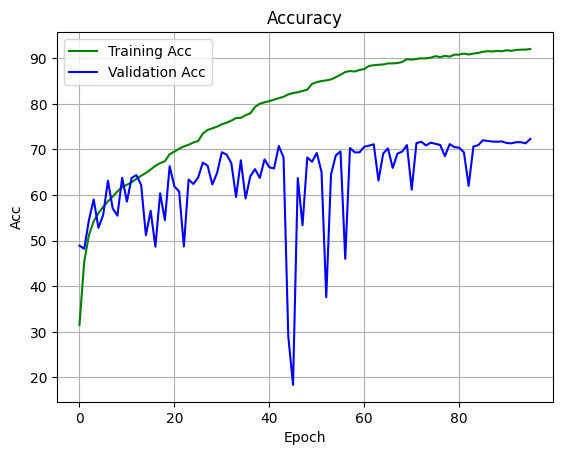

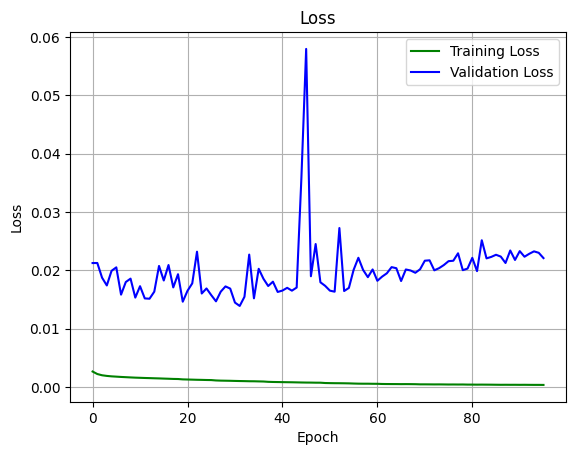

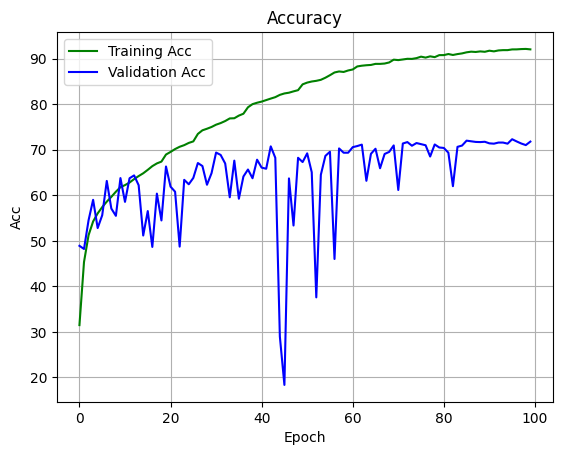

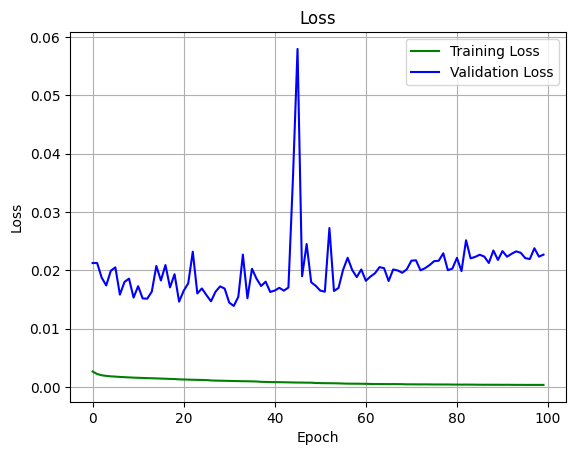

In [61]:
hps = setup_hparams()
logger, net = setup_network(hps)

run(net, logger, hps)

Evaluate

In [62]:
from PIL import Image
import glob

class TestingDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = []
        self.names = []

        self.images = sorted(glob.glob(f"{self.img_dir}/*"))
        self.names = [os.path.basename(image)[:-4] for image in self.images]

    def __len__(self):
        return len(self.images)

    def __getnames__(self):
        return self.names

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("L")
        image = self.transform(image)
        return image, self.names[idx]

In [63]:
test_data = TestingDataset(f"{unzip_path}/data/Images/test", test_transform)
print(f"Total testing data: {test_data.__len__()}")
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Total testing data: 3589


In [69]:
# 載入 checkpoint
checkpoint = torch.load('/content/checkpoints/my_vgg100/epoch_73')
# net = Vgg().to(device)
net.load_state_dict(checkpoint["params"])

<All keys matched successfully>

In [65]:
import pandas as pd

def evaluate_and_save_csv(net, dataloader, index_mapping, output_csv_path):
    net = net.eval()
    predictions = []
    filenames = []  # 用於儲存檔案名稱

    # 建立索引到類別名稱的映射

    class_dic = {v: k for k, v in index_mapping.items()}
    reverse_index_mapping = {k: v for v, k in index_mapping.items()}

    with torch.no_grad():
        for images, filepaths in dataloader:
            images = images.to(device)

            bs, ncrops, c, h, w = images.shape
            images = images.view(-1, c, h, w)

            # 模型前向傳播
            outputs = net(images)
            # combine results across the crops
            outputs = outputs.view(bs, ncrops, -1)
            outputs = torch.sum(outputs, dim=1) / ncrops
            preds = outputs.argmax(dim=-1).cpu().numpy().tolist()

            # 添加檔案名稱和預測結果
            filenames.extend(filepaths)
            predictions.extend(preds)

    # 建立 DataFrame 並保存為 CSV
    submission = pd.DataFrame({"filename": filenames, "label": predictions})
    submission.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

In [70]:
index_mapping = {"Angry": 0, "Disgust": 1, "Fear": 2, "Happy": 3, "Neutral": 4, "Sad": 5, "Surprise": 6}
output_csv_path = "/content/drive/MyDrive/ML/paper_VGG_73.csv"

evaluate_and_save_csv(net, test_loader, index_mapping, output_csv_path)

Predictions saved to /content/drive/MyDrive/ML/paper_VGG_73.csv


paper evaluate

In [31]:
def correct_count(output, target, topk=(1,)):
    """Computes the top k corrrect count for the specified values of k"""
    maxk = max(topk)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        res.append(correct_k)
    return res


In [32]:
def evaluate(net, dataloader, criterion):
    net = net.eval()
    loss_tr, n_samples = 0.0, 0.0

    y_pred = []
    y_gt = []

    correct_count1 = 0
    correct_count2 = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # fuse crops and batchsize
        bs, ncrops, c, h, w = inputs.shape
        inputs = inputs.view(-1, c, h, w)

        # forward
        outputs = net(inputs)

        # combine results across the crops
        outputs = outputs.view(bs, ncrops, -1)
        outputs = torch.sum(outputs, dim=1) / ncrops

        loss = criterion(outputs, labels)

        # calculate performance metrics
        loss_tr += loss.item()

        # accuracy
        counts = correct_count(outputs, labels, topk=(1, 2))
        correct_count1 += counts[0].item()
        correct_count2 += counts[1].item()

        _, preds = torch.max(outputs.data, 1)
        preds = preds.to("cpu")
        labels = labels.to("cpu")
        n_samples += labels.size(0)

        y_pred.extend(pred.item() for pred in preds)
        y_gt.extend(y.item() for y in labels)

    acc1 = 100 * correct_count1 / n_samples
    acc2 = 100 * correct_count2 / n_samples
    loss = loss_tr / n_samples
    print("--------------------------------------------------------")
    print("Top 1 Accuracy: %2.6f %%" % acc1)
    print("Top 2 Accuracy: %2.6f %%" % acc2)
    print("Loss: %2.6f" % loss)
    print("Precision: %2.6f" % precision_score(y_gt, y_pred, average='micro'))
    print("Recall: %2.6f" % recall_score(y_gt, y_pred, average='micro'))
    print("F1 Score: %2.6f" % f1_score(y_gt, y_pred, average='micro'))
    print("Confusion Matrix:\n", confusion_matrix(y_gt, y_pred), '\n')

In [33]:
criterion = nn.CrossEntropyLoss()
print("Train")
evaluate(net, train_loader, criterion)

print("Val")
evaluate(net, val_loader, criterion)

print("Test")
evaluate(net, test_loader, criterion)

Train
--------------------------------------------------------
Top 1 Accuracy: 76.879871 %
Top 2 Accuracy: 90.869508 %
Loss: 0.010212
Precision: 0.768799
Recall: 0.768799
F1 Score: 0.768799
Confusion Matrix:
 [[2232    1  313  101  280  267   19]
 [  85  137   79   12    8   29    1]
 [ 209    0 2129  121  274  342  193]
 [  36    0   51 5477  153   45   40]
 [ 106    1  112  252 3137  323   16]
 [ 273    0  358   96  565 2579   12]
 [  38    2  245  155   80   17 1966]] 

Val
--------------------------------------------------------
Top 1 Accuracy: 68.268896 %
Top 2 Accuracy: 84.883316 %
Loss: 0.014267
Precision: 0.682689
Recall: 0.682689
F1 Score: 0.682689
Confusion Matrix:
 [[ 464    0  109   37   94   69    9]
 [  24   31   14    0    8    8    0]
 [  84    0  455   32   92  109   57]
 [  16    0   31 1273   65   19    9]
 [  42    1   65   77  739   85    9]
 [ 100    0  164   35  193  449    6]
 [   9    0   79   41   24    6  509]] 

Test


ValueError: too many values to unpack (expected 2)